In [1]:
import numpy as np
import ast
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from src.embedding import EmbeddingModel, GTE
from src.paths import ORIGINAL_DATASET_CSV_PATH, PROCESSED_DATASET_CSV_PATH
from src.utils import clean_text, plot_word_cloud, lemmatize_text

In [2]:
df = pd.read_csv(ORIGINAL_DATASET_CSV_PATH)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
missing_values = df.isnull().sum()
missing_values_table = pd.DataFrame({
    "Column Name": df.columns,
    "Missing Values": missing_values,
    "Percentage (%)": (missing_values / len(df)) * 100
}).reset_index(drop=True)
missing_values_table

,Column Name,Missing Values,Percentage (%)
0,review,0,0.0
1,sentiment,0,0.0


In [4]:
if PROCESSED_DATASET_CSV_PATH.exists():
    print("Loading processed dataset...")
    df = pd.read_csv(PROCESSED_DATASET_CSV_PATH)
    df["gte_embedding"] = df["gte_embedding"].apply(ast.literal_eval)
    df["gte_embedding_lem"] = df["gte_embedding_lem"].apply(ast.literal_eval)
    df["encoded_sentiment"] = df["encoded_sentiment"].apply(int)

else:
    print("Processing dataset...")
    df["cleaned"] = df["review"].apply(clean_text)
    df["lemmatized"] = df["review"].apply(lemmatize_text)
    df["original_word_count"] = df["review"].apply(lambda x: len(str(x).split()))
    df["cleaned_word_count"] = df["cleaned"].apply(lambda x: len(str(x).split()))
    df["lemmatized_word_count"] = df["lemmatized"].apply(lambda x: len(str(x).split()))

original_unique_word_count = len(set(" ".join(df["review"]).split()))
cleaned_unique_word_count = len(set(" ".join(df["cleaned"]).split()))
lemmatized_unique_word_count = len(set(" ".join(df["lemmatized"]).split()))
df.head()

Processing dataset...


,review,sentiment,cleaned,lemmatized,original_word_count,cleaned_word_count,lemmatized_word_count
0,One of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode youll ...,reviewer mention watch oz episode hook right...,307,149,143
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...,wonderful little production br br filming tech...,162,80,83
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,think wonderful way spend time hot summer week...,166,75,73
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,basically family little boy jake think zombie ...,138,64,61
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,petter mattei love time money visually stunnin...,230,115,115


In [5]:
print(f"""Dataset Analysis:
Total entries: {len(df)}
Classes: {df["sentiment"].unique()}
    Positive count: {len(df.loc[df["sentiment"] == "positive"])}
    Negative count: {len(df.loc[df["sentiment"] == "negative"])}

Original:
    Total word count: {df["original_word_count"].sum()}
    Unique word count: {original_unique_word_count}
    MEAN word count per review: {df["original_word_count"].mean():.4f}
    STD word count per review: {df["original_word_count"].std():.4f}
    MAX word count in single review: {df["original_word_count"].max()}
    MIN word count in single review: {df["original_word_count"].min()}

Cleaned:
    Total word count: {df["cleaned_word_count"].sum()}
    Unique word count: {cleaned_unique_word_count}
    MEAN word count per review: {df["cleaned_word_count"].mean():.4f}
    STD word count per review: {df["cleaned_word_count"].std():.4f}
    MAX word count in single review: {df["cleaned_word_count"].max()}
    MIN word count in single review: {df["cleaned_word_count"].min()}

Lemmatized:
    Total word count: {df["lemmatized_word_count"].sum()}
    Unique word count: {lemmatized_unique_word_count}
    MEAN word count per review: {df["lemmatized_word_count"].mean():.4f}
    STD word count per review: {df["lemmatized_word_count"].std():.4f}
    MAX word count in single review: {df["lemmatized_word_count"].max()}
    MIN word count in single review: {df["lemmatized_word_count"].min()}
""")

Dataset Analysis:
Total entries: 50000
Classes: ['positive' 'negative']
    Positive count: 25000
    Negative count: 25000

Original:
    Total word count: 11557847
    Unique word count: 438729
    MEAN word count per review: 231.1569
    STD word count per review: 171.3440
    MAX word count in single review: 2470
    MIN word count in single review: 4

Cleaned:
    Total word count: 5336996
    Unique word count: 175588
    MEAN word count per review: 106.7399
    STD word count per review: 81.4261
    MAX word count in single review: 1318
    MIN word count in single review: 3

Lemmatized:
    Total word count: 5242121
    Unique word count: 154560
    MEAN word count per review: 104.8424
    STD word count per review: 80.5151
    MAX word count in single review: 1304
    MIN word count in single review: 3



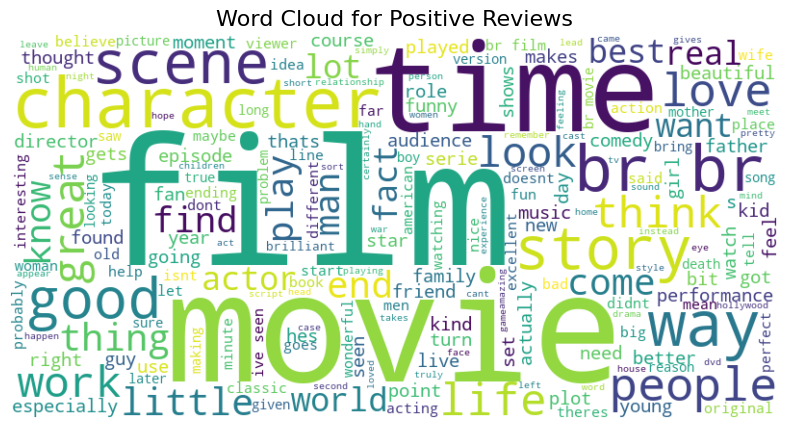

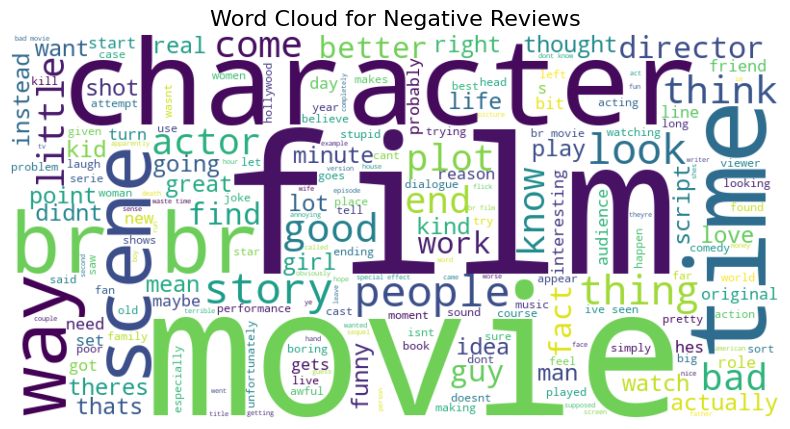

In [6]:
for sentiment in df["sentiment"].unique():
    text = " ".join(df[df["sentiment"] == sentiment]["cleaned"])
    plot_word_cloud(text, sentiment)

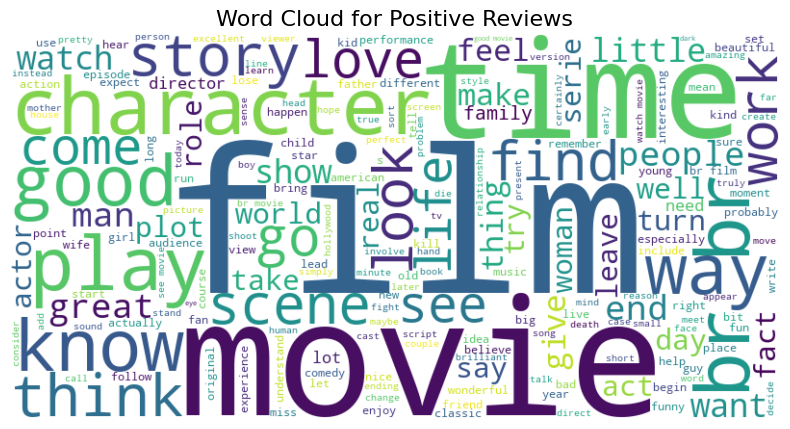

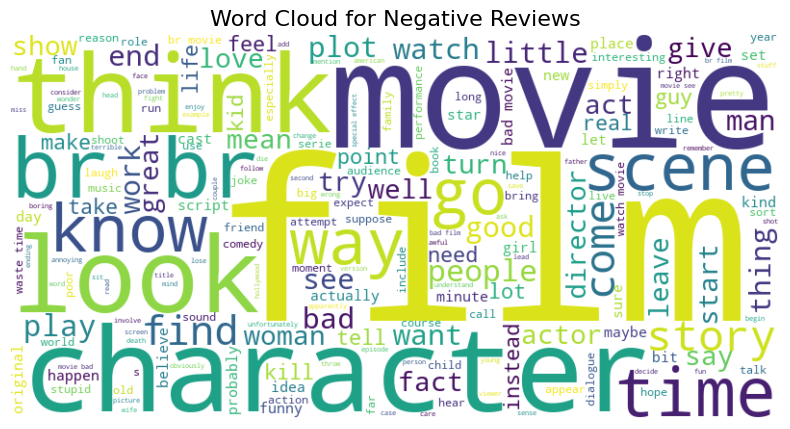

In [7]:
for sentiment in df["sentiment"].unique():
    text = " ".join(df[df["sentiment"] == sentiment]["lemmatized"])
    plot_word_cloud(text, sentiment)

In [8]:
embedding_model = EmbeddingModel(GTE.SMALL)
label_encoder = LabelEncoder()
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

if not PROCESSED_DATASET_CSV_PATH.exists():
    df["encoded_sentiment"] = label_encoder.fit_transform(df["sentiment"])
    df["gte_embedding"] = df["cleaned"].apply(embedding_model.get_embedding)
    df["gte_embedding_lem"] = df["lemmatized"].apply(embedding_model.get_embedding)
    df.to_csv(PROCESSED_DATASET_CSV_PATH, index=False)

df["tfidf_embedding"] = list(tfidf_vectorizer.fit_transform(df["cleaned"]).toarray())
df["tfidf_embedding_lem"] = list(tfidf_vectorizer.fit_transform(df["lemmatized"]).toarray())

print("Embedding dimension:", embedding_model.embedding_dim)
print("Max TF-IDF features:", tfidf_vectorizer.max_features)

Embedding dimension: 384
Max TF-IDF features: 5000


In [10]:
MODELS = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42, n_jobs=-1),
}

for embedding in ["gte_embedding", "gte_embedding_lem", "tfidf_embedding", "tfidf_embedding_lem"]:
    print(f"Using {embedding}")
    X = np.array(df[embedding].tolist())
    y = df["encoded_sentiment"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for name, model in MODELS.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(f"\n{name} Results:")
        print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

    print(f"{'=' * 60}\n")

Using gte_embedding

Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      5000
    positive       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Using gte_embedding_lem

Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.85      0.84      0.84      5000
    positive       0.84      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Using tfidf_embedding

Logistic Regression Results:
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy            